In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
sns.set_style('whitegrid')

### Global Functions

In [3]:
def withinRange(loc1, loc2, radius):
    return (loc1.distanceTo(loc2) < radius)

### System-wide Data types
#### not known by user

In [4]:
class Location():
    """
    Responsibility:
    This class stores the x-y coordinate of objects
    """
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def distanceTo(self, p):
        return ( (self.x - p.x)**2 + (self.y - p.y)**2 )**(0.5) # Euclidean distance
    
    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def getLocTup(self):
        return (self.x, self.y)

In [5]:
class Node():
    """
    This class represents an object that we are trying to get connected on our network.
    
    Attributes:
    - Location : Location
    - objects_within_range : list of nodes
    
    """
    # used in generating id's
    id = 1
    
    def __init__(self, x, y):
        self.loc = Location(x, y)
        self.objects_within_range = list()
        self.id = Node._generateId()
        
    def _generateId():
        temp = Node.id
        Node.id = Node.id + 1
        return temp
        
    def getId(self):
        return self.id
        
    def addObjWithinRange(self, node):
        """
        This object takes note of objects that are within 
        range of each other. 
        
        Parameters:
        - node : this is a Node object which is within range of self
        """
        
        self.objects_within_range.append(node)
        
    def removeObjectsWithinRange(self, objects_to_remove):
        """
        Responsibility:
        This function removes a list of items from the list of... 
        ...objects within range.
        
        Input: 
        - objects_to_remove: list
        
        Output:
        - None
        """
        new_objects_within_range = list()
        
        for node in self.objects_within_range:
            
            if(node not in objects_to_remove):
                new_objects_within_range.append(node)
                
        self.objects_within_range = new_objects_within_range
        

In [6]:
class Server():
    """
    This class represents an object that has the enclosing radius
    
    Attributes:
    - Location : Location
    - id : integer id
    - region_value: int denoting how many nodes this server connects to
    
    """
    # used in generating id's
    _id = 1
    
    def __init__(self, x, y, region_value):
        self.loc = Location(x, y)
        self.region_value = region_value
        self.id = Server._generateId()
        
    def _generateId():
        temp = Server._id
        Server.id = Server._id + 1
        return temp
        
    def getId(self):
        return self._id
                

In [7]:
class RegionType():
    """
    Responsibility;
    Store everything that has to do with a particular region
    """
    
    def __init__(self, region_id):
        
        self.region_id = frozenset(region_id)
        
        self.region_value = self.calculateRegionValue()
        self.points = list() # stores a list of points within the region
        self.best_position = None
    
    
    def calculateRegionValue(self):
        """
        Calculate the region's value
        """
        return len(self.region_id)
    
    def getRegionValue(self):
        return self.region_value
    
    def addPoint(self, point):
        self.points.append(point)
    
    def calculateBestPosition(self):
        """
        Computes the mean point within the region
        """
        sum_x = 0
        sum_y = 0
        
        # sum of all x's and y's
        for point in self.points:
            sum_x = sum_x + point.x
            sum_y = sum_y + point.y
        
        # compute average
        avg_x = sum_x / len(self.points)
        avg_y = sum_y / len(self.points)
        
        self.best_position = Location(avg_x, avg_y)
    
    def getBestPosition(self):        
        self.calculateBestPosition()
        return self.best_position


In [8]:
class RegionManager():
    """
    Responsibility:
    Manage all the types of regions 
    """
    
    def __init__(self):
        self.existing_regions = list()
    
    def getRegionFromId(self, region_id):
        """
        gets a region from its ID
        """
        
        for region in self.existing_regions:
            if(region_id == region.region_id):
                return region
            
        # return None if region not found
        return None        
    
    def createRegion(self, region_id):
        """
        Creates a region and adds it to the list of existing regions
        And returns the created region to the caller
        """
        
        self.existing_regions.append(RegionType(region_id))
        return self.existing_regions[-1]
        
        
    def addPoint(self, point, region_formers):
        """
        This adds a point to a region, if it exists
        if it doesn't exist, the region is created and the point added
        """
        
        # convert region_formers to a frozenset
        region_id = frozenset(region_formers)
        
        region_found = self.getRegionFromId(region_id)
        
        
        if(region_found != None):
            # if it found a region, add the point to that region
            region_found.addPoint(point)
            
        else:
            # if it didn't find a region, create a new one
            # and add the point to the new region

            self.createRegion(region_id).addPoint(point)
            
    def getRecommendedPoints(self):
        """
        Returns a pandas dataframe (columns= location, region_value)...
        containing all the best location for all the regions 
        """
        
        # list of dictionaries
        recomm_points = pd.DataFrame(columns=['Location', 'Region_Value'])
        
        # getting the best position and region value for each region
        for region in self.existing_regions:
            recomm_points = recomm_points.append({'Location' : region.getBestPosition(), 'Region_Value': region.getRegionValue()}, ignore_index=True)
            
        # at this point, valid_points should be populated with records of each region's...
        # ...best position and region_value
        
        # sort the toble based on region_value (in descending order) 
        recomm_points.sort_values(by=['Region_Value'], axis='index', inplace=True, ascending=False)
        
        return recomm_points          

In [9]:
class SimluationResults():
    """
    Responsibility:
    Store the results of the simulation  
    """
    
    def __init__(self):
        
        # the data structure is a bit convoluted but it begins with a list
        self.progressive_results = list()
        
        # keep track of the number of saved states
        self.num_of_states = 0
        
    def __updateNumOfStates(self):
        self.num_of_states = self.num_of_states + 1 
        
    def __extractServerState(self, servers):
        """
        Responsibility:
        Extract the location and region values of servers
        
        Returns:
        A list of dictionaries
        """
        
        # output 
        servers_state = list()
        
        # convert each server object to a dictionary
        # ... and append it to the output list
        for server in servers:
            
            # data structure for each entry
            server_data = {
                'location': server.loc.getLocTup(),
                'region_value' : server.region_value 
            }
            
            servers_state.append(server_data)
            
        return servers_state
            
    def __extractNodeState(self, nodes):
        """
        Responsibility:
        Extract the location of nodes

        Returns:
        A list of dictionaries
        """

        # output 
        nodes_state = list()

        # convert each unserved node object to a dictionary
        # ... and append it to the output list
        for node in nodes:

            # data structure for each entry
            node_data = {
                'location': node.loc.getLocTup()
            }

            nodes_state.append(node_data)
            
        return nodes_state
    
    def saveState(self, servers, unserved_nodes, served_nodes):
        
        
        # state of all servers
        servers_state = self.__extractServerState(servers) 
            
        # state of all unserved_nodes
        unserved_nodes_state = self.__extractNodeState(unserved_nodes)
        
        # state of all served_nodes
        served_nodes_state = self.__extractNodeState(served_nodes)
        
        current_total_state = {
            "servers": servers_state,
            "unserved_nodes": unserved_nodes_state,
            "served_nodes":  served_nodes_state
        }
        
        self.progressive_results.append(current_total_state)
        
        self.__updateNumOfStates()
        
        
    def getServerStateAt(self, index):
        # returns list of dictionaries
        return self.progressive_results[index]["servers"]
    
    def getUnservedNodeStateAt(self, index):
        # returns list of dictionaries
        return self.progressive_results[index]["unserved_nodes"]
    
    def getServedNodeStateAt(self, index):
        # returns list of dictionaries
        return self.progressive_results[index]["served_nodes"]            
        
        

In [10]:
class Simluator():
    """
    Responsibility:
    Run the simulation
    """
    
    
    def __init__(self):
        
        self.state_variables = SimulationStateVariables()
        self.simulation_results = SimluationResults()
        
        # number of times the simulation has been run
        self.__sim_count = 0
        
        
    def resetSimulator(self):
        """
        Responsibility:
        Reset the the simulation (copy of __init__)
        """
        self.state_variables = SimulationStateVariables()
        self.simulation_results = SimluationResults()
        
        # number of times the simulation has been run
        self.__sim_count = 0
        
        
    def setInitialState(self, unserved_nodes):
        """
        Input:
        unserved_nodes: list of Nodes
        """
        self.state_variables.unserved_nodes = unserved_nodes
    
    def __findNodesWithinRange(self):
        """
        Responsibility:
        Finds all the nodes within range of every unserved node
        """
        for ref_node in self.state_variables.unserved_nodes:
            for test_node in self.state_variables.unserved_nodes:
                # continue if the node is already known to be within range
                # ... or if the test and ref node are the same
                if ((ref_node is test_node) or (test_node in ref_node.objects_within_range)):
                    continue

                if (withinRange(ref_node.loc, test_node.loc, SimulationConstants.radius*2)):

                    ref_node.addObjWithinRange(test_node)
                    test_node.addObjWithinRange(ref_node)
        
    
    def __findMostConnectedObject(self):
        """
        Returns the most connected unserved_node.
        Returns None if no object is within range of another
        """
        most_number_of_connections = 0
        most_connected_object = None
        
        for node in self.state_variables.unserved_nodes:
            
            if((len(node.objects_within_range) > most_number_of_connections)):
                most_connected_object = node
                most_number_of_connections = len(node.objects_within_range)
        
        return most_connected_object
        
    def __clearNodesWithinRange(self):
        """
        Responsibility:
        Clear served nodes from the list of nodes_within_range 
        for all unserved nodes 
        """
        
        for node in self.state_variables.unserved_nodes:
            node.removeObjectsWithinRange(self.state_variables.served_nodes)
        
    def __updateSimCount(self):
        self.__sim_count = self.__sim_count + 1
        
    def getSimCount(self):
        return self.__sim_count
    
    def __findRecommendedPoints(self, no_intersecting_regions, most_connected_object):
        """
        Returns:
        - pandas dataframe of recommended_server locations and their region_value
        """
        
        # Creating the region manager
        region_manager = RegionManager()
        
        # Case 1: no intersecting regions
        if(no_intersecting_regions):
            
            # if there no intersecting region, then every node gets its own server      
            for node in self.state_variables.unserved_nodes:
                    region_manager.addPoint(node.loc, {node.getId()})

        # Case 2: there are intersecting regions
        else:
            
            # to make the code lest verbose
            r = SimulationConstants.radius
            
            for r_scale in np.linspace(1, 0, 50): # reducing the radius by scaling it 
                for theta in np.linspace(0, 2*np.pi, 100): # performing 360* rotation
                    test_x = r_scale * r * np.cos(theta) + most_connected_object.loc.x
                    test_y = r_scale * r * np.sin(theta) + most_connected_object.loc.y

                    test_location = Location(test_x, test_y)

                    # store the id's of all nodes that intersect... 
                    # ...beginning with the most connected node
                    intersecting_nodes = set([most_connected_object.getId()])

                    # determine the nodes that are intersecting at that point
                    for node in most_connected_object.objects_within_range:


                        # take note of nodes within range of the point
                        if(withinRange(test_location, node.loc, r)):
                            intersecting_nodes.add(node.getId())

                    # add tell the region manager about this point
                    region_manager.addPoint(test_location, intersecting_nodes)

        # after all points have been computed
        # retrieve the recommended points from the region manager
        return region_manager.getRecommendedPoints()
    
    def __getHighestRegionValue(self, recommended_points):
        return recommended_points['Region_Value'].max()
    
    def __getBestLocations(self, recommended_points):
        """
        Responsibility:
        Extract the best recommended points from the list of recommended points
        
        Returns:
        list of location objects (best location)
        """
        
        # the highest region value 
        max_region_value = self.__getHighestRegionValue(recommended_points)

        best_locations = list()

        for index, vp in recommended_points.iterrows():
            if(vp['Region_Value'] == max_region_value):
                best_locations.append(vp['Location'])
            else:
                break
                
        return best_locations
    
    def __placeServers(self, best_locations, region_value):
        """
        Responsibility:
        Place the servers at the best locations 
        """
        if(region_value !=1):
            for point in best_locations[:1]: # place one server at a time when points are not isolated
                self.state_variables.servers.append(Server(point.x, point.y, region_value))
        else:
            # when region value is 1 (that is, the point is isolated)
            # ... place all servers simultaneously
            for point in best_locations:
                self.state_variables.servers.append(Server(point.x, point.y, region_value))

        
    def __findNewlyServedNodes(self):
        """
        Responsibility:
        Find all the unserved nodes within range of the server
        Update the list of served_nodes
        
        Returns:
        list of newly served nodes
        """
        
        newly_served_nodes = list()
        
        for node in self.state_variables.unserved_nodes:
            for server in self.state_variables.servers:
                

                if(node in newly_served_nodes):
                    continue
                
                # within range? (bool)
                within_range = withinRange(server.loc, node.loc, SimulationConstants.radius)
                
                if(within_range):
                    newly_served_nodes.append(node)
                    
                    # also append to the list of served_nodes
                    self.state_variables.served_nodes.append(node)
                    
        return newly_served_nodes 
        
    def __updateUnservedNodes(self):
        """
        Responsibility:
        Remove newly served nodes from unserved nodes list
        """
        
        # find all newly served nodes
        newly_served_nodes = self.__findNewlyServedNodes()
        
        # remove list of newly served nodes from unserved nodes
        new_unserved_nodes = list()
        
        for unserved_node in self.state_variables.unserved_nodes:
            if(unserved_node not in newly_served_nodes):
                new_unserved_nodes.append(unserved_node)
        
        
        self.state_variables.unserved_nodes = new_unserved_nodes
        
    def runSimulation(self):
        
        while(len(self.state_variables.unserved_nodes) != 0):
            # fist, clear the Nodes of all knowledge of objects in range
            self.__clearNodesWithinRange()
            
            # find the nodes within range of evey node
            # ... if this is the first run
            if(self.__sim_count == 0):
                self.__findNodesWithinRange()
            
            # find most connected object
            most_connected_object = self.__findMostConnectedObject()
            
            # are there intersecting regions?
            no_intersecting_regions = (most_connected_object == None)
            
            # find possible server points (recommended_points)
            recommended_points = self.__findRecommendedPoints(no_intersecting_regions, most_connected_object)            
            
            # out of all the recommended points, get the best location
            best_locations = self.__getBestLocations(recommended_points)

            # place servers in the best locations
            self.__placeServers(best_locations, self.__getHighestRegionValue(recommended_points))
                       
            
            # update the list of unserved and served nodes
            self.__updateUnservedNodes()
            
            # save simulation results
            self.simulation_results.saveState(self.state_variables.servers, 
                                              self.state_variables.unserved_nodes, 
                                              self.state_variables.served_nodes)
            
            # update the simulation count
            self.__updateSimCount()
            

In [11]:
class SimulationConstants():
    """
    Responsibility:
    Store the constants that the simulation uses
    """
    radius = None
    circle_x = None
    circle_y = None
    
    def computeCircleConstant(r):
        """
        Responsibility:
        Genereates the points (x, y) for a circle of radius r 
        """
        
        theta = np.linspace(0, 2*np.pi, 100)
        SimulationConstants.circle_x = r * np.cos(theta)
        SimulationConstants.circle_y = r * np.sin(theta)
        
        SimulationConstants.radius = r

In [12]:
class SimulationStateVariables():
    """
    Responsibility:
    Store the variables that the simulation uses (while runing)

    Implications of that responsibility:
        - updates the variables upon request
        - ouputs the variables/data upon request

    """
    
    def __init__(self):
        self.servers = list()
        self.unserved_nodes = list()
        self.served_nodes = list()
        

In [13]:
class SimulationParameters():
    """
    Responsibility:
        - "Convert and" Store the parameters (input) from the simulation
            - conversion don using the conversion function(s)
    """
    
    
    
    def __init__(self):
        self.nodes = list()
        self.distribution_radius = 0
        
    
    def pointsToNodes(self, points):
        """
        Responsibility:
        - Convert point to Node objects
        
        Input:
            - points: list of tuples [(x, y), (x, y)]
        
        Returns:
            - list of Node objects
        """
        
        nodes = list()
        
        for point in points:
            nodes.append(Node(point[0], point[1]))
            
        return nodes
        
    
    def setNodeLocations(self, points):
        """
        Responsibility:
            - Recieve a list of tuples (xy coordinates) from the user...
        """
        
        # convert points and  Locations assign
        self.nodes = self.pointsToNodes(points)
        
    def setRadius(self, dist_radius):
        
        # radius can't be zero
        if (dist_radius == 0):
            print("radius can't be zero")
            return 
        
        self.distribution_radius = dist_radius
        
        # generate the cirlce points in SimulationConstant
        SimulationConstants.computeCircleConstant(dist_radius)
    
    def getNodes(self):
        return self.nodes
    
    def getRadius(self):
        return self.radius
        

### The following class acts as the user interface

In [14]:
class System():
    """
    Responsibility:
        - Act as an interface between the user and the simulation system
        
    Implications of that responsibility:
        - accepts input parameters from the user
        - gives user requested output/data
    """
    
    # class variables
    points = "nodes"
    distribution_radius = "distribution_radius"
    
    
    def __init__(self):
        self.simulation_parameters = SimulationParameters()
        self.simulator = Simluator()
        self.simulation_resuts = None
        
    def numOfIterations(self):
        return self.simulator.getSimCount()
        
    def run(self):
        """
        Responsibility:
        Run the system to calculate the optimal locations
        """
        
        # if the simulation has been run before 
        # ...clear the simulation and its results 
        if(self.simulator.getSimCount() > 0):
            self.simulator.resetSimulator()
        
        # set initial state
        self.simulator.setInitialState(self.simulation_parameters.getNodes())
        
        # rum simulation
        self.simulator.runSimulation()
        
        
        # get results
        self.simulation_resuts = self.simulator.simulation_results
        
    
    def setParameters(self, dict_of_params):
        """
        Responsibility:
        Set the parameters for the simulation
        
        Input:
        dict_of_params: dictionary of objects
                        Eg: {System.points: [(x1, y1), (x2, y2)], 
                            System.distribution_radius: 5}
        Returns: 
        None
        """
        
        # set Points
        self.simulation_parameters.setNodeLocations(dict_of_params[System.points])
        
        # set radius
        self.simulation_parameters.setRadius(dict_of_params[System.distribution_radius])
        
    def getFinalResults(self):
        """
        Returns a dictionary containing lists of dictionaries, yeah.
        Firs Layer (Dictionary): 
        The dictionary has 3 fields:
                - "servers" : contains the list of all the servers (and their properties) a the end 
                             ...of the simulation
                - "unserved_nodes" : contains the list of all the unserved_nodes (and their properties) a the end 
                             ...of the simulation
                             
                - "served_nodes" : contains the list of all the served_nodes (and their properties) a the end 
                             ...of the simulation
        
        Second Layer (List):
        This list contains all the items of the selected type (either server, unserved_nodes, or served_nodes)
        Each element in this dictionary of to attributes of each object
        
        Thrid and final Layer (Dictionary):
        The dictionary has 1 or 2 fields (Servers have 2, the rest have 1)
        The fields include:
                - "location" : contains a tuple of the (x,y) coordinate of the object
                - "region_value" : (server only) COntains the region value of the server.
        """
        
        return self.getProgessiveResults()[-1]
        
    def getProgessiveResults(self):
        """
        Returns a list of dictionaries containing lists of dictionaries, yeah.
        
        Break down:
        First Layer (list): List of Dictionaries containing:
            - server_states
            - unserved_node_states
            - served_node_states
            
            Each element (i.e. dictionary) in the list represents each iteration of the simulation
            
                             
        Second Layer (Dictionary): 
        The dictionary has 3 fields:
                - "servers" : contains the list of all the servers (and their properties) a the end 
                             ...of some iteration in the simulation
                - "unserved_nodes" : contains the list of all the unserved_nodes (and their properties) a the end 
                             ...of some iteration in the simulation
                             
                - "served_nodes" : contains the list of all the served_nodes (and their properties) a the end 
                             ...of some iteration in the simulation
        
        Third Layer (List):
        This list contains all the items of the selected type (either server, unserved_nodes, or served_nodes)
        Each element in this dictionary of to attributes of each object
        
        Fourth and final Layer (Dictionary):
        The dictionary has 1 or 2 fields (Servers have 2, the rest have 1)
        The fields include:
                - "location" : contains a tuple of the (x,y) coordinate of the object
                - "region_value" : (server only) COntains the region value of the server.
        """
        
        return self.simulation_resuts.progressive_results
        
    

### Here is where the user can interact with the system
Class and function definitions end here

In [15]:
system = System()

In [16]:
x_size = 16
y_size = x_size * 9/16
number_of_points = 39
radius = 2.2
points = [(np.random.randint(0, x_size), np.random.randint(0, y_size)) for _ in range(number_of_points)]
#points = [(-2,0), (0,2), (2,0)]

In [17]:
system.setParameters(
    {
        System.points: points,
        System.distribution_radius: radius
    }    
)

system.run()

circle_x = SimulationConstants.circle_x
circle_y = SimulationConstants.circle_y

### Visualizing the results

#### Visualizeing the scene before the algorithm runs

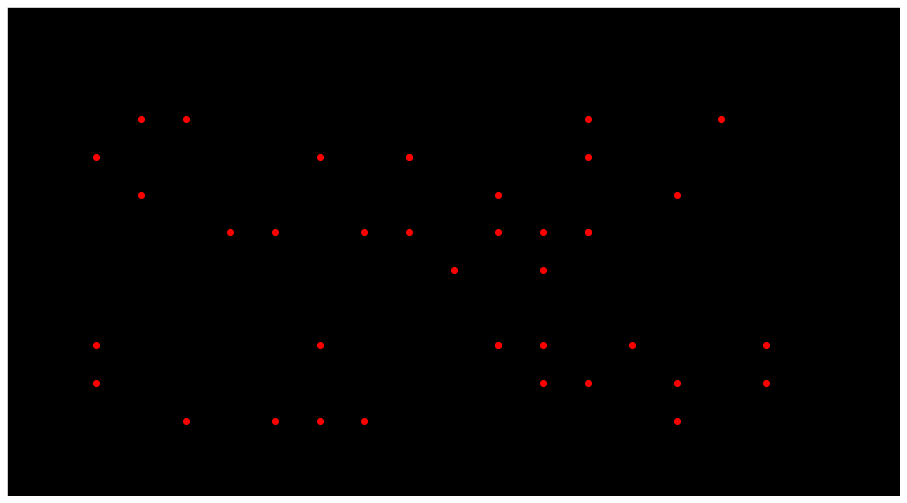

In [18]:
index = -1
final_servers = system.getProgessiveResults()[index]['servers']
final_served_nodes = system.getProgessiveResults()[index]['served_nodes']
final_unserved_nodes = system.getProgessiveResults()[index]['unserved_nodes']

plt.figure(figsize=(16, 9))
plt.style.use("dark_background")
plt.grid(False)
#sns.despine(left=True, bottom=True)
plt.yticks([])
plt.xticks([])
plt.xlim((-2,x_size+2))
plt.ylim((-2,y_size+2))


for node in final_served_nodes:

    node_loc = node['location']

    #place the served_node
    plt.plot(node_loc[0], node_loc[1], 'ro', alpha=1)


for node in final_unserved_nodes:
    node_loc = node['location']

    #place the server
    plt.plot(node_loc[0], node_loc[1], 'ro', alpha=1)  


#plt.show()
plt.savefig("github points.png", dpi=72)

#### Visualizing the results of the algorithm progressively

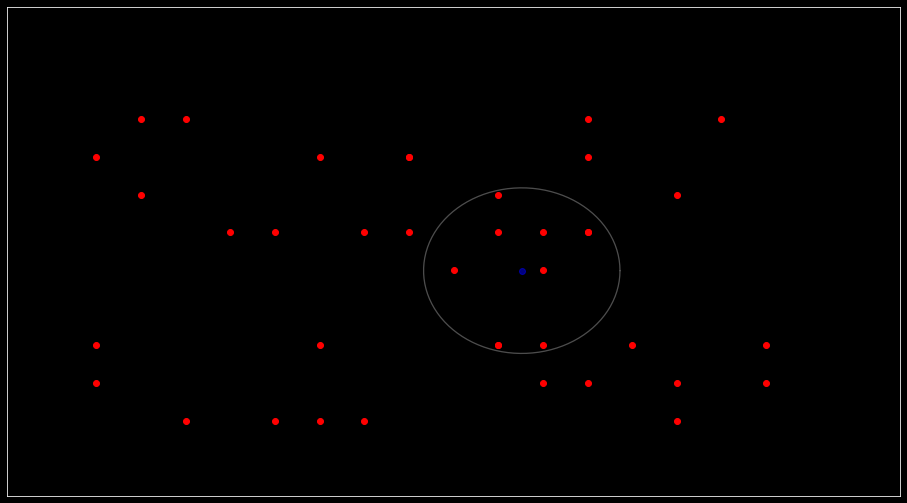

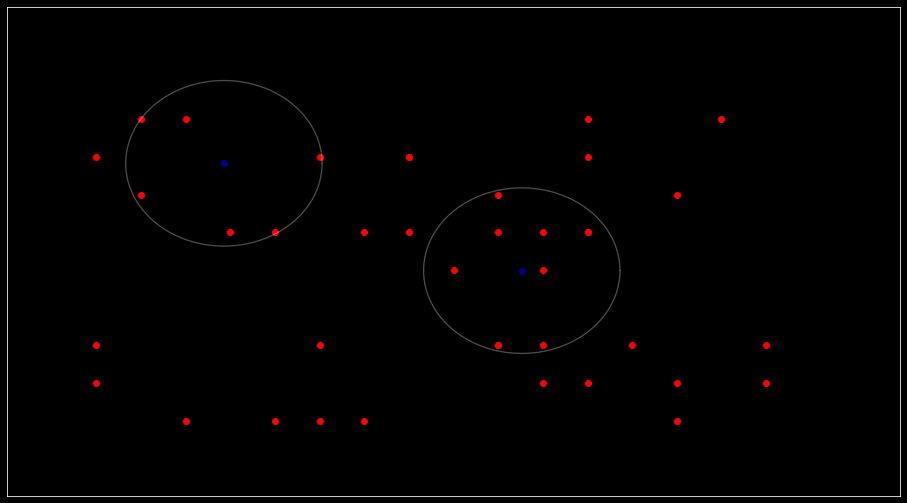

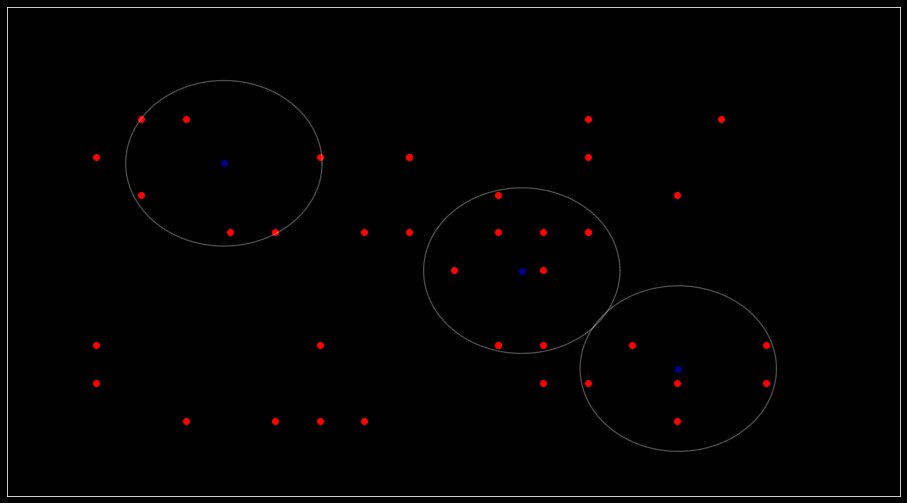

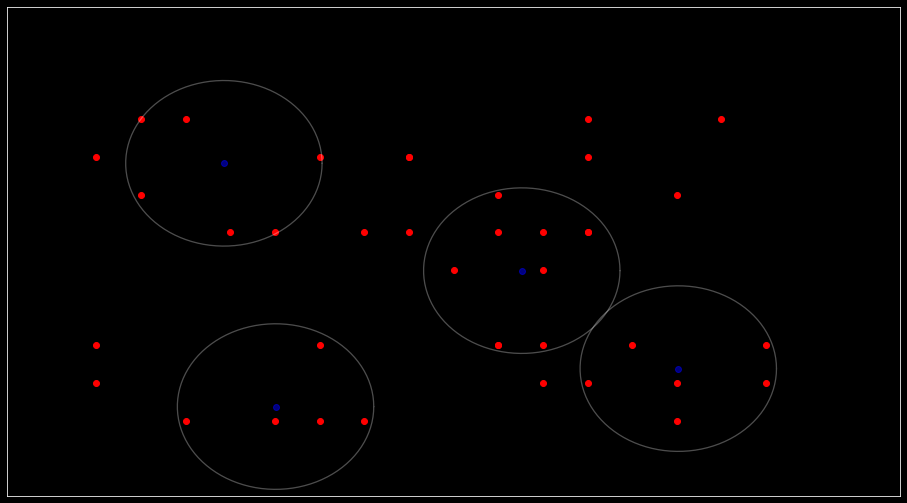

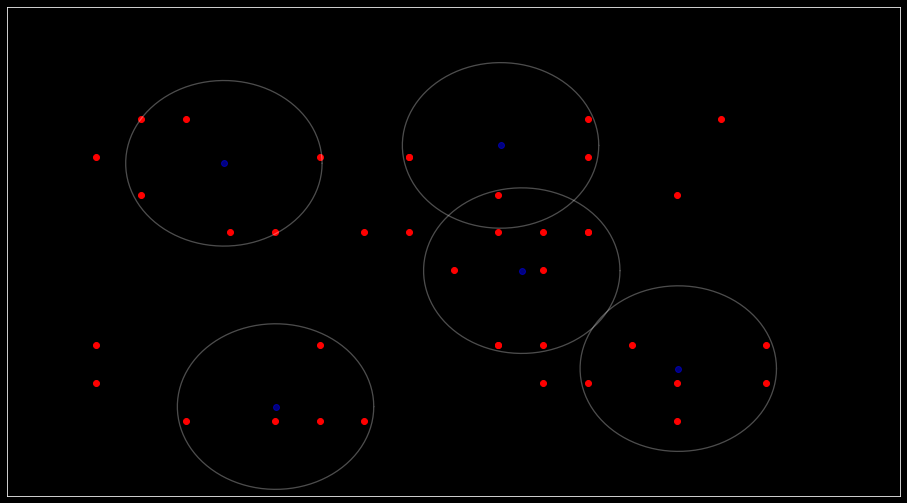

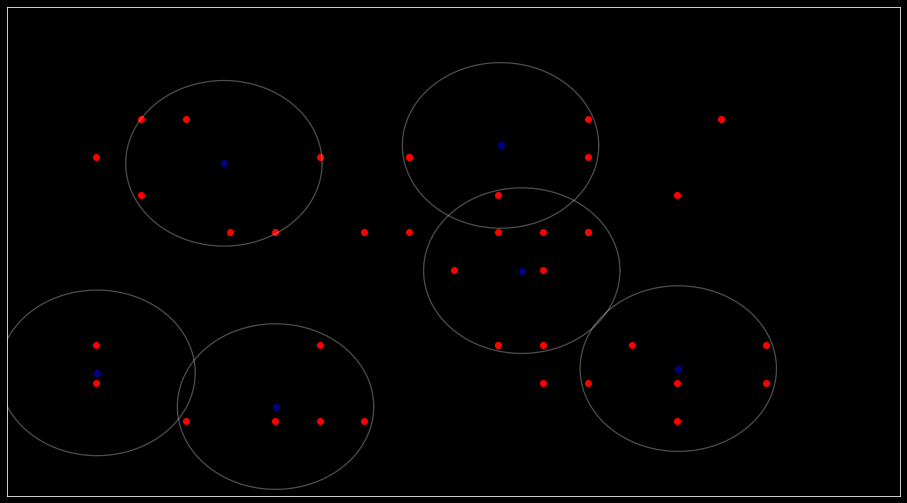

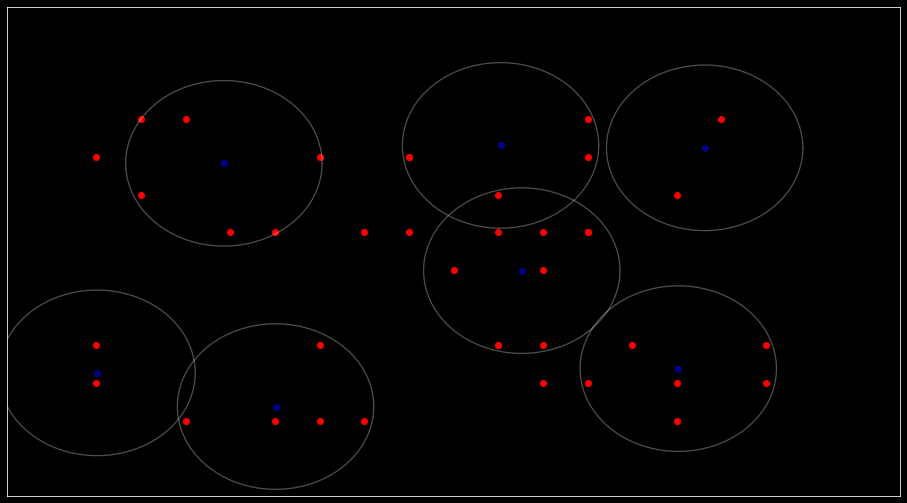

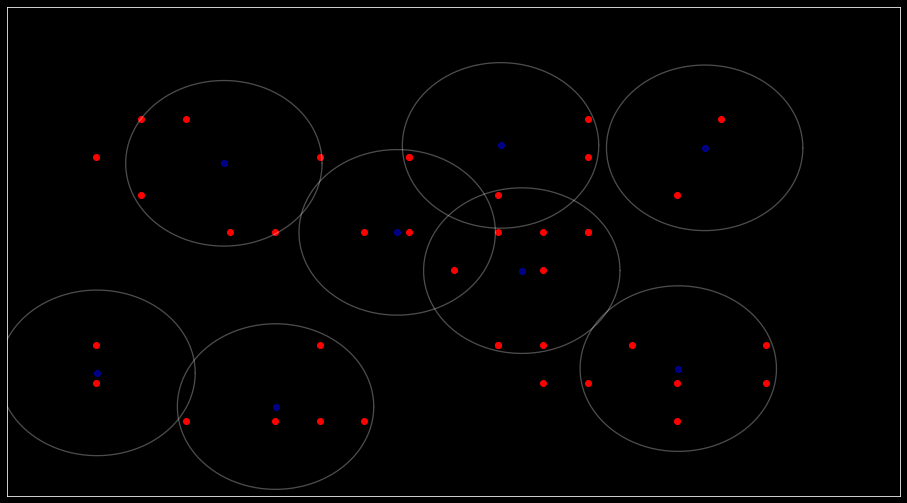

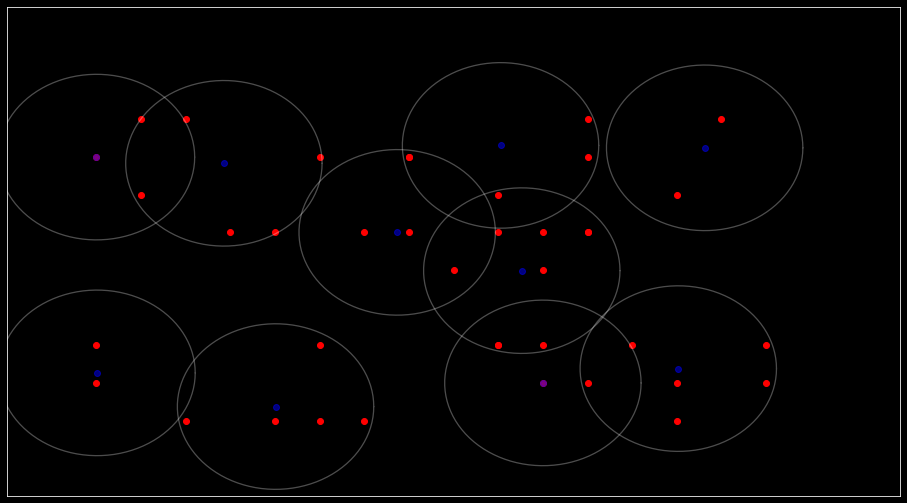

In [19]:
for index in range(system.numOfIterations()):
    
    plt.figure(figsize=(16, 9))
    plt.style.use("dark_background")
    plt.grid(False)
    #sns.despine(left=True, bottom=True)
    plt.yticks([])
    plt.xticks([])
    plt.xlim((-2,x_size+2))
    plt.ylim((-2,y_size+2))
    
    final_servers = system.getProgessiveResults()[index]['servers']
    final_served_nodes = system.getProgessiveResults()[index]['served_nodes']
    final_unserved_nodes = system.getProgessiveResults()[index]['unserved_nodes']

    for node in final_served_nodes:
        node_loc = node['location']

        #place the served_node
        plt.plot(node_loc[0], node_loc[1], 'ro', alpha=1)


    for node in final_unserved_nodes:
        node_loc = node['location']

        #place the server
        plt.plot(node_loc[0], node_loc[1], 'ro', alpha=1)  

    for server in final_servers:

        server_loc = server['location']
        #server_reg_val = server['region_value']

        # place the server
        plt.plot(server_loc[0], server_loc[1], 'bo', alpha=0.5)

        # place the region circle around the server
        plt.plot(server_loc[0]+circle_x, server_loc[1]+circle_y, color='white', lw=1.3, alpha=0.3)

    #plt.show()
    plt.savefig("./Github/"+str(index+1)+".png", dpi=72)

In [20]:
print("Number of iterations:", system.numOfIterations())

Number of iterations: 9


In [21]:
print("Number of servers:",  len(system.getFinalResults()['servers']))

Number of servers: 10
